In [1]:
#Goal: Create word vectors from a King Lear
#and analyze them to semantic similarity

#Step 0 - Import dependencies
#future is the missing compatibility layer between Python 2 and Python 3. 
#It allows you to use a single, clean Python 3.x-compatible codebase to 
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
#for word encoding
import codecs
#regex, matches pathnames
import glob
#concurrency
import multiprocessing
#dealing with operating system, like reading a file
import os
#pretty printing, human readable
import pprint
#regular expressions
import re
#natural language toolkit
import nltk
#word 2 vec
import gensim.models.word2vec as w2v
#dimensionality reduction
import sklearn.manifold
#math
import numpy
import matplotlib.pyplot as plt
#parse pandas as pad
import pandas as pd
#visualization
import seaborn as sns
#graph
import plotly.plotly as py
import plotly.graph_objs as go

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
#Step 1 - Process our data
#clean data
nltk.download('punkt') #pretrained tokenizer
nltk.download('stopwords') #words like and, the, an, a, of remove common words

[nltk_data] Downloading package punkt to /Users/linguini/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/linguini/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
#get the book names, matching txt file
book_filenames = sorted(glob.glob("./kinglear/klmodified.txt"))

In [5]:
#print books
print("Found books:")
book_filenames

Found books:


['./kinglear/klmodified.txt']

In [6]:
#initialize rawunicode, we'll add all text to this on file in memory
corpus_raw = u""
#for each book, read it, open it in utf 8 format,
#add it to the raw corpus
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} character")

Reading './kinglear/klmodified.txt'...
Corpus is now {0} character


In [7]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [8]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [9]:
#covert into a list of words
#remove unnecessary, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]", " ", raw)
    words = clean.split()
    return words

In [10]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [11]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

His breeding, sir, hath been at my charge: I have
so often blushed to acknowledge him, that now I am
brazed to it.
['His', 'breeding', 'sir', 'hath', 'been', 'at', 'my', 'charge', 'I', 'have', 'so', 'often', 'blushed', 'to', 'acknowledge', 'him', 'that', 'now', 'I', 'am', 'brazed', 'to', 'it']


In [12]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 26,878 tokens


## Train Word2Vec

In [13]:
#Step 3 - Build model

#Once we have vectors
#3 main tasks that vectors help with
#Distance, similarity, ranking

#Dimensionality of the resulting word vectors
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimsions = more generalized
num_features = 300

#Minimum word count threshold
min_word_count = 3

#Number of threads to run in parallel
#more workers, the faster we train
num_workers = multiprocessing.cpu_count()

#Context window length
context_size = 7

#Downsample setting for frequent words
#0 - 1e-5 is good for this
downsampling = 1e-3

#Seed for the RNG, to make the results reproducible
#random number generator
#deterministic, good for debugging
seed = 1

In [14]:
ss2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [15]:
ss2vec.build_vocab(sentences)

In [16]:
print("Word2Vec Vocabulary Length:", len(ss2vec.vocab))

Word2Vec Vocabulary Length: 1250


In [17]:
ss2vec.train(sentences)

85057

#### Save to file for later use 

In [18]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [19]:
ss2vec.save(os.path.join("trained", "ss2vec.w2v"))

## Explore the trained model

In [20]:
ss2vec = w2v.Word2Vec.load(os.path.join("trained", "ss2vec.w2v"))

In [21]:
#squash dimensionality to 2
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [22]:
all_word_vectors_matrix = ss2vec.syn0

### Train t-SNE

In [23]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

#### Plot the big picture

In [24]:
#plot point in 2d space
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[ss2vec.vocab[word].index])
            for word in ss2vec.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [25]:
points.head(10)

,word,x,y
0,I,-2.315424,0.314059
1,King,-8.809091,-3.095338
2,Lear,3.831384,-0.317309
3,s,10.709625,-5.608309
4,palace,-11.251746,-2.472730
5,Enter,-0.034136,17.161022
6,and,9.277428,-1.193089
7,thought,-17.501556,-10.018413
8,the,13.413355,-2.942851
9,king,-9.258752,-14.426306


In [26]:
#plot
sns.set_context("poster")

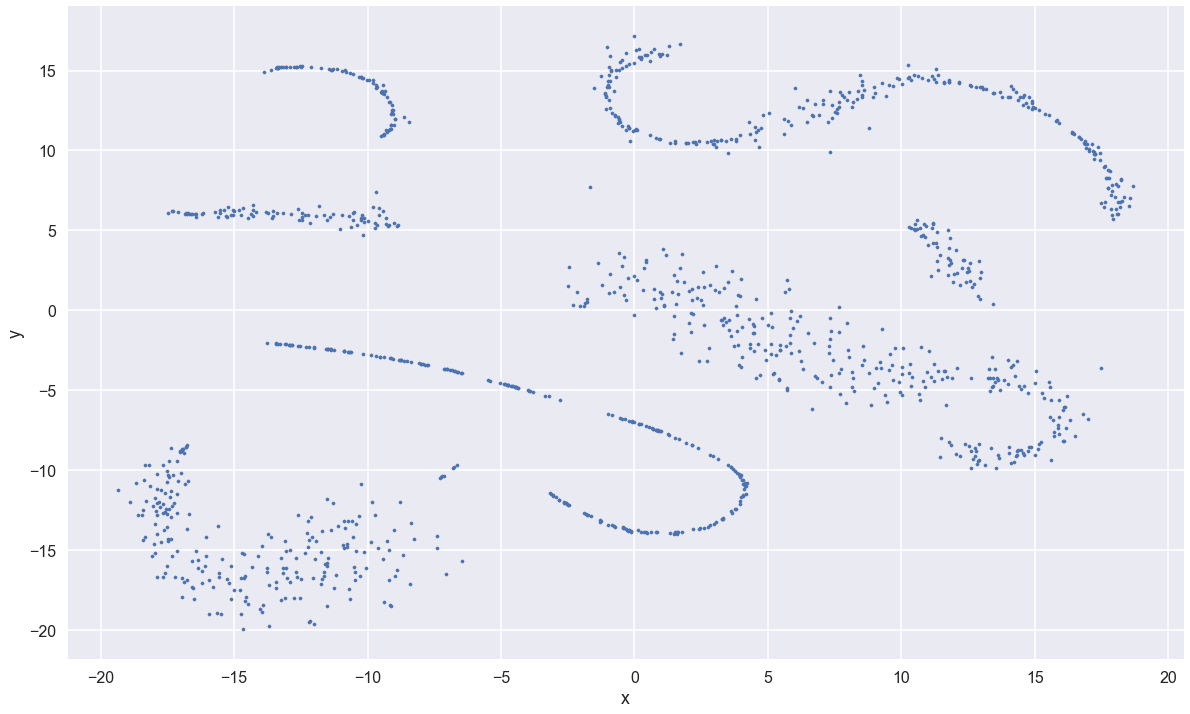

In [27]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [28]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.05, point.y + 0.05, point.word, fontsize=11)

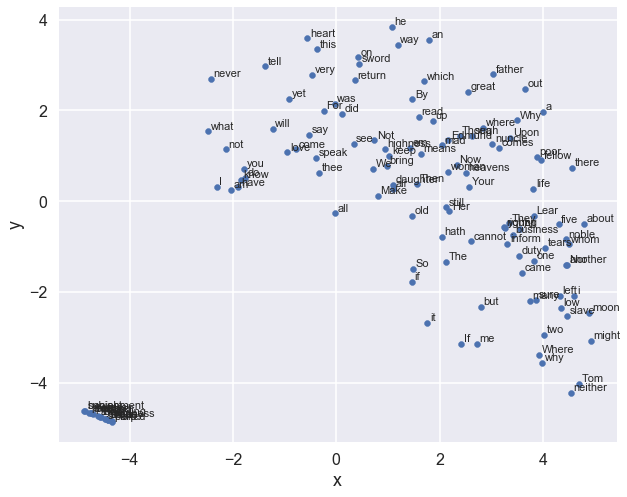

In [29]:
plot_region(x_bounds=(-5,5), y_bounds=(-5, 5))

In [30]:
fig = {
    'data': [
  		{
  			'x': points.x, 
        	'y': points.y, 
        	'text': points.word, 
        	'mode': 'markers'}
    ],
    'layout': {
        'xaxis': {'title': 'x'},
        'yaxis': {'title': "y"}
    }
}
py.iplot(fig)

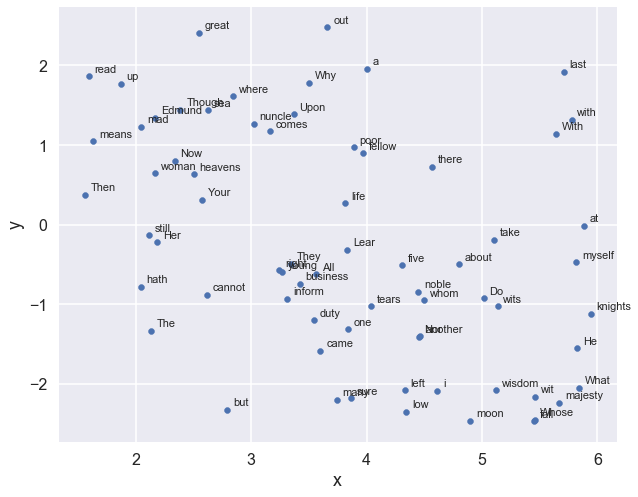

In [42]:
plot_region(x_bounds=(1.5, 6.0), y_bounds=(-2.5, 2.5))

In [32]:
ss2vec.most_similar("Lear")

[('rest', 0.9998416304588318),
 ('last', 0.999838650226593),
 ('others', 0.9998362064361572),
 ('safe', 0.999834418296814),
 ('fierce', 0.9998339414596558),
 ('rain', 0.9998317956924438),
 ('self', 0.9998307228088379),
 ('vile', 0.9998294115066528),
 ('reason', 0.999828577041626),
 ('something', 0.9998284578323364)]

In [33]:
ss2vec.most_similar("Goneril")

[('hard', 0.9998547434806824),
 ('loved', 0.9998503923416138),
 ('low', 0.9998483061790466),
 ('last', 0.9998465776443481),
 ('favour', 0.9998455047607422),
 ('ear', 0.9998447299003601),
 ('without', 0.9998438358306885),
 ('neither', 0.9998407363891602),
 ('seem', 0.9998403787612915),
 ('shape', 0.9998403787612915)]

In [34]:
ss2vec.most_similar("Kent")

[('read', 0.9998589754104614),
 ('On', 0.9998542070388794),
 ('alone', 0.9998529553413391),
 ('strike', 0.9998525381088257),
 ('honour', 0.9998518228530884),
 ('inform', 0.9998500347137451),
 ('strange', 0.9998494982719421),
 ('once', 0.9998481273651123),
 ('low', 0.9998473525047302),
 ('sea', 0.9998469352722168)]

In [35]:
#distance, similarity, and ranking
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = ss2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [36]:
#nearest_similarity_cosmul("Lear", "Cordelia", "Goneril")
#nearest_similarity_cosmul("Lear", "map", "sword")
#nearest_similarity_cosmul("Lear", "hysteria", "daughter")

In [37]:
ss2vec.vocab['Lear']